# Burger equation in 1D: joint estimation (vanilla inverse problem)

Consider the following PDE:
$$
\begin{cases}
\frac{\partial}{\partial t} u(t,x) + u(t,x)\frac{\partial}{\partial x}
          u(t,x) - \nu \frac{\partial^2}{\partial x^2} u(t,x) = 0,\\
          u(0, x) = -\sin(\pi x), \text{ (temporal boundary condition)}\\
u(t,-1)=u(t,1)=0, \text{ (boundary condition)}
\end{cases}
$$

This has been studied in [this article](https://www.mdpi.com/2073-4441/13/4/423) for example.

In this notebook we jointly estimate the equation solution with a PINN and the equation parameter $\nu$. To do so we follow the methodology straightforward methodology from _Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations_, Raissi et al., 2019, i.e., we minimize the dynamic loss with respect to both the neural network parameters and the equation parameters. We also make use of a batch of available observations. See more explanation at [this page](https://hgangloff.pages.mia.inra.fr/pinn_experiments/param_estim_pinn.html)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Float64 and GPU settings

In [2]:
#import os; os.environ["JAX_ENABLE_X64"] = "TRUE" # comment/uncomment to  disable/enable float64 for JAX
#import os; os.environ["CUDA_VISIBLE_DEVICES"]="" # If uncommented then GPU is disable

Import our package

In [3]:
import jinns

Import other dependencies

In [4]:
import jax
import numpy as np
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx
from functools import partial
import matplotlib.pyplot as plt

key = random.PRNGKey(2)
key, subkey = random.split(key)

## Observations

We use artificial observations from the estimated solution from the other notebook on Burger equation.

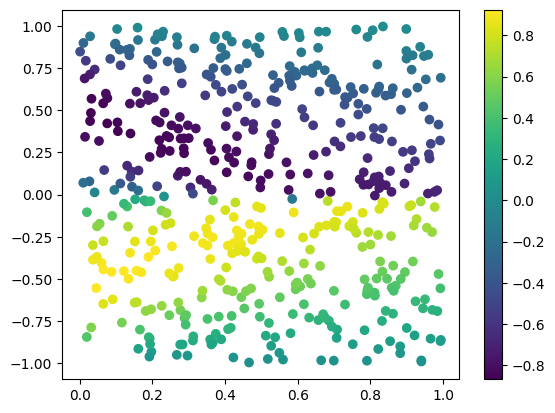

In [5]:
observations = jnp.load("burger_solution_grid.npy")
key, subkey = jax.random.split(key)
size_subsample = 500
time_subsample = jax.random.choice(
    subkey,
    jnp.arange(0, observations.shape[0], 1),
    shape=(size_subsample,),
    replace=False
)
key, subkey = jax.random.split(key)
size_subsample = 500
omega_subsample = jax.random.choice(
    subkey,
    jnp.arange(0, observations.shape[1], 1),
    shape=(size_subsample,),
    replace=False
)
obs_batch = observations[
    time_subsample,
    omega_subsample
]

plt.scatter(obs_batch[:, 0], obs_batch[:, 1], c=obs_batch[:, 2])
plt.colorbar()
plt.show()

__Optionally blur the observed values__

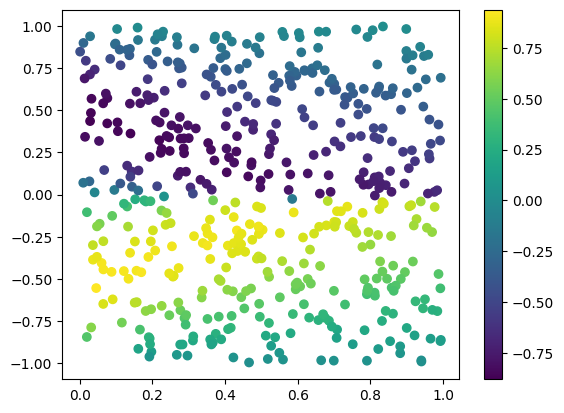

In [6]:
obs_batch_ori = obs_batch.copy()
key, subkey = jax.random.split(key)
obs_batch = obs_batch.at[:, 2].set(
    obs_batch[:, 2] +
    random.normal(subkey, obs_batch[:, 2].shape) * 0.01
)


plt.scatter(obs_batch[:, 0], obs_batch[:, 1], c=obs_batch[:, 2])
plt.colorbar()
plt.show()

Create the neural network architecture for the PINN with `equinox`. Note that we will use the same architecture for the 3 populations.

In [7]:
eqx_list = [
    [eqx.nn.Linear, 3, 50],
    [jax.nn.tanh],
    [eqx.nn.Linear, 50, 50],
    [jax.nn.tanh],
    [eqx.nn.Linear, 50, 50],
    [jax.nn.tanh],
    [eqx.nn.Linear, 50, 1]
]
key, subkey = random.split(key)
init_param_fn, u = jinns.utils.create_PINN(subkey, eqx_list, "nonstatio_PDE", 1, with_eq_params=["nu"])
init_nn_params = init_param_fn()

Create a DataGenerator object

In [8]:
n = 500
nt = 500
nb = 2
omega_batch_size = 32
temporal_batch_size = 32
omega_border_batch_size = 1
dim = 1
xmin = -1
xmax = 1
tmin = 0
tmax = 1
Tmax = 1
method = "uniform"

train_data = jinns.data.CubicMeshPDENonStatio(
    subkey,
    n,
    nb,
    nt,
    omega_batch_size,
    omega_border_batch_size,
    temporal_batch_size,
    dim,
    (xmin,),
    (xmax,),
    tmin,
    tmax,
    method
)

## Model parameters

__Optionally blur the initial parameter value__

In [9]:
# True is : nu = 1 / (100 * jnp.pi)
key, subkey = jax.random.split(key)
nu_ori = 1 / (100 * jnp.pi)
print(nu_ori)
nu = nu_ori + random.normal(subkey, shape=(1,)) * 0.001
print(nu)

0.0031830988618379067
[0.00390729]


A set of parameters as required by the losses' `evaluate` functions is a dictionary with the neural network parameters `nn_params` and the equation parameters `eq_params`. Here we construct this dictionary

In [10]:
init_params = {
    "nn_params":init_nn_params,
    "eq_params":{
        "nu":nu
    }
}

## Initial condition

Text(0.5, 1.0, 'Init condition $u_0$')

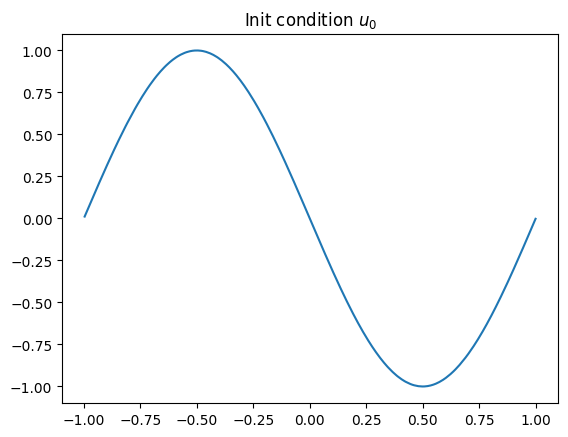

In [11]:
def u0(x):
    return -jnp.sin(jnp.pi * x)

plt.plot(train_data.omega.sort(axis=0), vmap(u0, (0), 0)(train_data.omega.sort(axis=0)))
plt.title(r"Init condition $u_0$")

## Loss construction

__Note: An important thing to note in the next cell is the derivative argument set to "both". This means that we will differentiate the Dynamic Loss both with respect to nn_params and eq_params.__

In [12]:
be_loss = jinns.loss.BurgerEquation(Tmax=Tmax, derivatives="both")

In [13]:
loss_weights = {"dyn_loss":1, "temporal_loss":1, "boundary_loss":1, "observations":1e2}
    
loss = jinns.loss.LossPDENonStatio(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=be_loss,
    omega_boundary_fun=lambda dx: 0,
    omega_boundary_condition="dirichlet",
    temporal_boundary_fun=u0,
    obs_batch=[obs_batch[:, 0], obs_batch[:, 1], obs_batch[:, 2]]
)

In [14]:
# Testing the loss function
losses_and_grad = jax.value_and_grad(loss.evaluate, 0, has_aux=True)
key, subkey = random.split(key)
losses, grads = losses_and_grad(
    init_params,
    batch = train_data.get_batch()
)


l_tot, d = losses
print(f"total loss: {l_tot:.2f}")
print(f"Individual losses: { {key: f'{val:.2f}' for key, val in d.items()} }")

total loss: 34.25
Individual losses: {'boundary_loss': '0.01', 'dyn_loss': '0.00', 'norm_loss': '0.00', 'observations': '33.66', 'temporal_loss': '0.58'}


## Joint estimation of `eq_params` and `nn_params`

In [15]:
params = init_params

In [16]:
# Optimizer
import optax
tx = optax.adam(learning_rate=1e-4)

In [17]:
n_iter = int(300000)

Next we define which parameter we want to track. For each one we give a list of keys that correspond to the path of the parameter in `params`

In [18]:
tracked_params_key_list = [
    ['eq_params', 'nu']
]

Then optimization starts

In [19]:
key, subkey = random.split(key, 2)
params, total_loss_list, loss_by_term_dict, train_data, loss, _, tracked_params = jinns.solve(
    init_params=params,
    data=train_data,
    tracked_params_key_list=tracked_params_key_list,
    optimizer=tx,
    loss=loss,
    n_iter=n_iter
)

Iteration 0: loss value = 34.07251739501953


  0%|          | 0/300000 [00:00<?, ?it/s]

Iteration 1000: loss value = 2.4180662631988525
Iteration 2000: loss value = 1.2653264999389648
Iteration 3000: loss value = 0.7972671389579773
Iteration 4000: loss value = 0.5479778051376343
Iteration 5000: loss value = 0.4199425280094147
Iteration 6000: loss value = 0.291007936000824
Iteration 7000: loss value = 0.2707027792930603
Iteration 8000: loss value = 0.25056231021881104
Iteration 9000: loss value = 0.15625381469726562
Iteration 10000: loss value = 0.15747156739234924
Iteration 11000: loss value = 0.13737748563289642
Iteration 12000: loss value = 0.13138189911842346
Iteration 13000: loss value = 0.1477799117565155
Iteration 14000: loss value = 0.11432892829179764
Iteration 15000: loss value = 0.12381145358085632
Iteration 16000: loss value = 0.09757138043642044
Iteration 17000: loss value = 0.11201176792383194
Iteration 18000: loss value = 0.08032116293907166
Iteration 19000: loss value = 0.0969865471124649
Iteration 20000: loss value = 0.08738590776920319
Iteration 21000: lo

## Results

Plot the tracked parameters

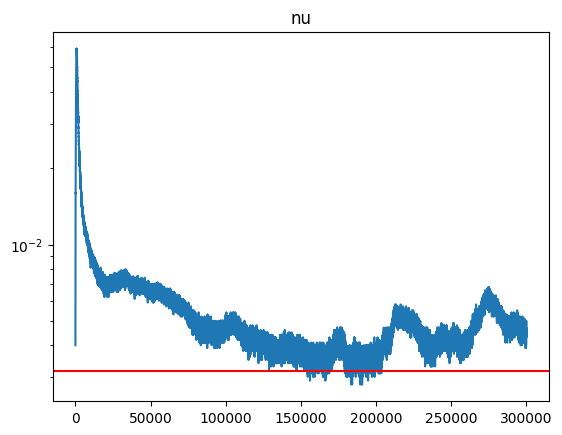

In [20]:
colors = ['blue']
plt.semilogy(tracked_params[tracked_params_key_list[0][0]][tracked_params_key_list[0][1]])
plt.axhline(y=nu_ori, color='r', linestyle='-')
plt.title(f"nu")
plt.show()

Plot the loss values

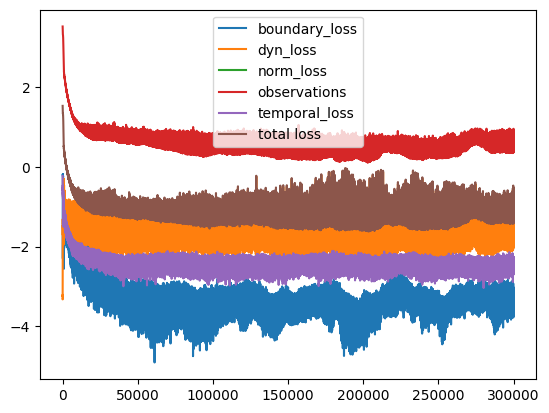

In [21]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_weights[loss_name] * loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show();

Plot the PDE solutions learned by the PINN

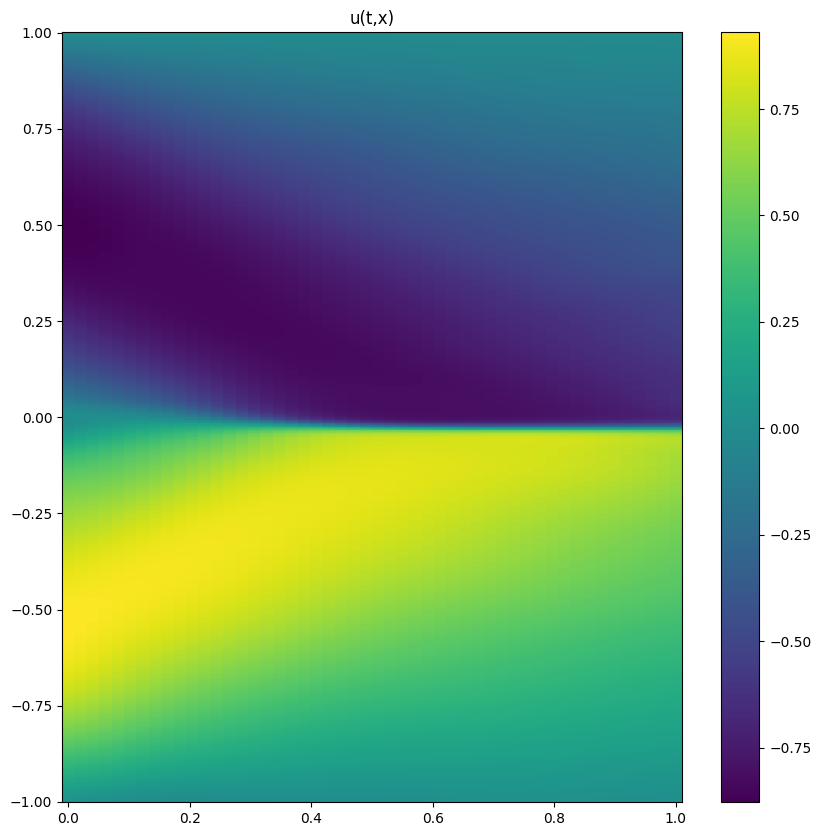

In [22]:
u_est = partial(u, u_params=params["nn_params"], eq_params=params["eq_params"])
nx = 1000
val_xdata = jnp.linspace(xmin, xmax, nx)
ntime = 50
val_times = jnp.linspace(tmin, tmax, ntime)
jinns.data.plot1d_image(u_est, xdata=val_xdata, times=val_times, cmap="viridis", colorbar=True, figsize=(10,10), title="u(t,x)")

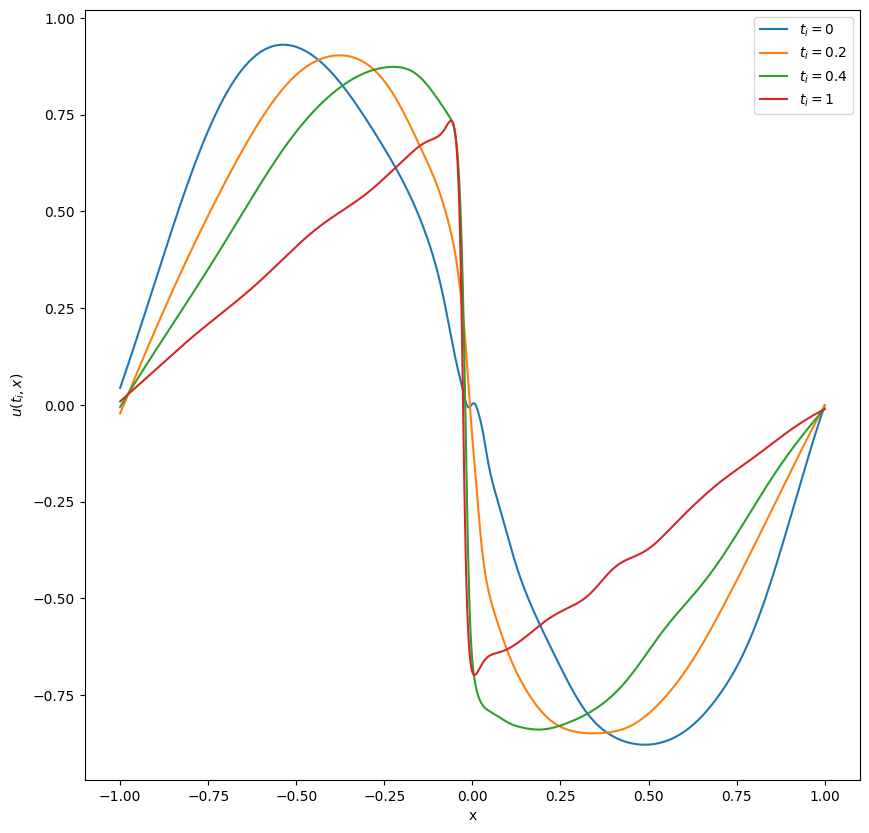

In [23]:
time_slices = [0, 0.2, 0.4, 1]
jinns.data.plot1d_slice(u_est, xdata=val_xdata, time_slices=time_slices)